### ISIC 2018 Skin Lesion Classification - EfficientNet B1



In [1]:
%%capture
!pip install -r requirements.txt


In [2]:
# Cell 1: Import các module và cấu hình
import warnings
warnings.filterwarnings('ignore')

import sys
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Import custom modules từ thư mục scr
from scr.config import *
from scr.data_processing import load_all_data
from scr.dataset import ISICDataset
from scr.transforms import get_train_transform, get_val_transform
from scr.model import build_model, count_parameters, load_checkpoint, save_checkpoint, print_model_info
from scr.train import train_one_epoch, create_dataloaders, get_optimizer, get_scheduler, get_criterion
from scr.evaluate import evaluate, plot_confusion_matrix, print_classification_report, create_submission, visualize_predictions

# Set random seed
set_seed(SEED)

# Print configuration
print_config()

print(f"\n✓ All modules imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

CONFIGURATION
Device: cpu
Random Seed: 42

Model: efficientnet_b1
Input Size: 224x224
Number of Classes: 7

Batch Size: 64
Learning Rate: 0.0001
Weight Decay: 0.001
Number of Epochs: 5
Early Stop Patience: 3

Model Path: outputs\models\efficientnet_b1_isic2018.pt

✓ All modules imported successfully!
PyTorch version: 2.9.1+cpu
CUDA available: False


In [3]:
# Cell 2: Load và chuẩn bị dữ liệu

# Load all data
df_train, df_val, df_test, label2idx, idx2label, num_classes, use_weighted_sampler = load_all_data(
    PATH_TRAIN_CSV, PATH_VAL_CSV, PATH_TEST_CSV,
    DIR_TRAIN_IMG, DIR_VAL_IMG, DIR_TEST_IMG
)

# Store label mappings in config (for checkpoint saving)
LABEL2IDX = label2idx
IDX2LABEL = idx2label

# Create datasets
train_transform = get_train_transform()
val_transform = get_val_transform()

train_dataset = ISICDataset(df_train, transform=train_transform)
val_dataset = ISICDataset(df_val, transform=val_transform)
test_dataset = ISICDataset(df_test, transform=val_transform)

print(f"\n✓ Datasets created:")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

# Create dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    df_train, df_val, df_test,
    train_dataset, val_dataset, test_dataset,
    BATCH_SIZE, NUM_WORKERS, use_weighted_sampler
)

print(f"\n✓ Dataloaders created:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Val: {len(val_loader)} batches")
print(f"  Test: {len(test_loader)} batches")


LOADING DATA

=== TRAIN DATASET ===
Total samples: 10015

Label distribution:
  AKIEC: 327 (3.27%)
  BCC: 514 (5.13%)
  BKL: 1099 (10.97%)
  DF: 115 (1.15%)
  MEL: 1113 (11.11%)
  NV: 6705 (66.95%)
  VASC: 142 (1.42%)

=== VAL DATASET ===
Total samples: 193

Label distribution:
  AKIEC: 8 (4.15%)
  BCC: 15 (7.77%)
  BKL: 22 (11.40%)
  DF: 1 (0.52%)
  MEL: 21 (10.88%)
  NV: 123 (63.73%)
  VASC: 3 (1.55%)

=== TEST DATASET ===
Total samples: 1512

Label distribution:
  AKIEC: 43 (2.84%)
  BCC: 93 (6.15%)
  BKL: 217 (14.35%)
  DF: 44 (2.91%)
  MEL: 171 (11.31%)
  NV: 909 (60.12%)
  VASC: 35 (2.31%)

=== LABEL MAPPING ===
Number of classes: 7
  0: AKIEC
  1: BCC
  2: BKL
  3: DF
  4: MEL
  5: NV
  6: VASC

=== CLASS IMBALANCE ANALYSIS ===
Class imbalance ratio: 58.30
Max class count: 6705
Min class count: 115
High class imbalance detected (ratio > 3.0).
   Will use WeightedRandomSampler for balanced training.

DATA LOADING COMPLETE

✓ Datasets created:
  Train: 10015 samples
  Val: 193 sa

In [4]:
# Cell 3: Khởi tạo model và training components

# Build model
model = build_model(num_classes=num_classes, pretrained=True, model_name=MODEL_NAME)
model = model.to(DEVICE)

# Print model info
print_model_info(model, MODEL_NAME.upper())

# Setup training components
optimizer = get_optimizer(model, LEARNING_RATE, WEIGHT_DECAY)
scheduler = get_scheduler(optimizer, NUM_EPOCHS, USE_COSINE_SCHEDULER)
criterion = get_criterion(USE_LABEL_SMOOTHING, LABEL_SMOOTHING)

# Initialize mixed precision scaler
from torch.cuda.amp import GradScaler
scaler = GradScaler() if torch.cuda.is_available() else None

print("\n✓ Model and training components initialized!")


MODEL INFORMATION
Model: EFFICIENTNET_B1
Total parameters: 6,522,151
Trainable parameters: 6,522,151
Optimizer: AdamW (lr=0.0001, weight_decay=0.001)
Scheduler: CosineAnnealingLR (T_max=5)
Loss: CrossEntropyLoss with label smoothing (0.1)

✓ Model and training components initialized!


In [5]:
# Cell 4: Training Stage
from scr.engine import train_model
import scr.config as config

# 1. Initialize history and tracking
history = {
    'epoch': [], 'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_bal_acc': [], 'lr': []
}
best_val_f1 = 0.0
best_epoch = 0
start_epoch = 0

# 2. Load existing checkpoint if it exists
if os.path.exists(MODEL_PATH):
    checkpoint = load_checkpoint(model, optimizer, MODEL_PATH, DEVICE)
    start_epoch = checkpoint.get('epoch', 0)
    best_val_f1 = checkpoint.get('best_val_f1', 0.0)
    best_epoch = checkpoint.get('best_epoch', 0)
    if 'history' in checkpoint:
        history = checkpoint['history']
    print(f" Resumed from epoch {start_epoch}")
else:
    print(" Starting fresh training")

# 3. Prepare config for engine
cfg_dict = {
    'VAL_EVERY_N_EPOCHS': config.VAL_EVERY_N_EPOCHS,
    'SAVE_EVERY_N_EPOCHS': config.SAVE_EVERY_N_EPOCHS,
    'EARLY_STOP_PATIENCE': config.EARLY_STOP_PATIENCE,
    'USE_COSINE_SCHEDULER': config.USE_COSINE_SCHEDULER,
    'MODEL_PATH': config.MODEL_PATH,
    'NUM_CLASSES': config.NUM_CLASSES,
    'label2idx': label2idx,
    'idx2label': idx2label
}

# 4. Run Training
model, history, best_val_f1, best_epoch = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=config.NUM_EPOCHS,
    device=DEVICE,
    config_dict=cfg_dict,
    start_epoch=start_epoch,
    best_val_f1=best_val_f1,
    best_epoch=best_epoch,
    history=history
)


Loading checkpoint from: outputs\models\efficientnet_b1_isic2018.pt
Loaded checkpoint from epoch 8, best F1: 0.7268
 Resumed from epoch 8
Training for 5 epochs (from 8 to 13)

Epoch 9/13


Training:   0%|          | 0/157 [00:00<?, ?it/s]

 Train Loss: 0.7774 | Train Acc: 0.9211
 Running validation...
 Val Loss: 1.0518 | Val Acc: 0.7409 | Val F1: 0.6805
 No improvement (1/3)
Checkpoint saved: outputs\models\efficientnet_b1_isic2018.pt

Epoch 10/13


Training:   0%|          | 0/157 [00:00<?, ?it/s]

 Train Loss: 0.6261 | Train Acc: 0.9460
 Running validation...
 Val Loss: 0.9801 | Val Acc: 0.7668 | Val F1: 0.6833
 No improvement (2/3)
Checkpoint saved: outputs\models\efficientnet_b1_isic2018.pt

Epoch 11/13


Training:   0%|          | 0/157 [00:00<?, ?it/s]

 Train Loss: 0.5893 | Train Acc: 0.9615
 Running validation...
 Val Loss: 0.9022 | Val Acc: 0.8187 | Val F1: 0.7345
New best model! F1: 0.7345
Checkpoint saved: outputs\models\efficientnet_b1_isic2018.pt

Epoch 12/13


Training:   0%|          | 0/157 [00:00<?, ?it/s]

 Train Loss: 0.5733 | Train Acc: 0.9654
 Running validation...
 Val Loss: 0.8670 | Val Acc: 0.8342 | Val F1: 0.7289
 No improvement (1/3)
Checkpoint saved: outputs\models\efficientnet_b1_isic2018.pt

Epoch 13/13


Training:   0%|          | 0/157 [00:00<?, ?it/s]

 Train Loss: 0.5666 | Train Acc: 0.9687
 Running validation...
 Val Loss: 0.8583 | Val Acc: 0.8342 | Val F1: 0.7305
 No improvement (2/3)
Checkpoint saved: outputs\models\efficientnet_b1_isic2018.pt

 Training Stage Complete!
 Best: Epoch 11 | F1: 0.7345


In [10]:
# Cell 5: Đánh giá trên Validation Set

# Load best model
print("Loading best model...")
checkpoint = load_checkpoint(model, None, MODEL_PATH, DEVICE)

# Evaluate on validation set
print("\nEvaluating on validation set...")
val_loss, val_acc, val_f1, val_bal_acc, val_preds, val_labels, val_probs, val_image_ids = evaluate(
    model, val_loader, criterion, DEVICE
)

print(f"\nValidation Results:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_acc:.4f}")
print(f"  Macro F1: {val_f1:.4f}")
print(f"  Balanced Accuracy: {val_bal_acc:.4f}")

# Confusion Matrix
plot_confusion_matrix(
    val_labels, val_preds, idx2label,
    save_path=os.path.join(DIR_FIGURES, 'val_confusion_matrix.png'),
    title='Validation Confusion Matrix'
)

# Classification Report
print_classification_report(val_labels, val_preds, idx2label)

Loading best model...
Loading checkpoint from: outputs\models\efficientnet_b1_isic2018.pt
Loaded checkpoint from epoch 13, best F1: 0.7345

Evaluating on validation set...

Validation Results:
  Loss: 0.8583
  Accuracy: 0.8342
  Macro F1: 0.7305
  Balanced Accuracy: 0.8245
✓ Confusion matrix saved: outputs\figures\val_confusion_matrix.png

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       AKIEC     0.5000    0.5000    0.5000         8
         BCC     0.6842    0.8667    0.7647        15
         BKL     0.6800    0.7727    0.7234        22
          DF     0.3333    1.0000    0.5000         1
         MEL     0.6667    0.7619    0.7111        21
          NV     0.9640    0.8699    0.9145       123
        VASC     1.0000    1.0000    1.0000         3

    accuracy                         0.8342       193
   macro avg     0.6897    0.8245    0.7305       193
weighted avg     0.8556    0.8342    0.8410       193



'              precision    recall  f1-score   support\n\n       AKIEC     0.5000    0.5000    0.5000         8\n         BCC     0.6842    0.8667    0.7647        15\n         BKL     0.6800    0.7727    0.7234        22\n          DF     0.3333    1.0000    0.5000         1\n         MEL     0.6667    0.7619    0.7111        21\n          NV     0.9640    0.8699    0.9145       123\n        VASC     1.0000    1.0000    1.0000         3\n\n    accuracy                         0.8342       193\n   macro avg     0.6897    0.8245    0.7305       193\nweighted avg     0.8556    0.8342    0.8410       193\n'

In [11]:
# Cell 6: Đánh giá trên Test Set

# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_acc, test_f1, test_bal_acc, test_preds, test_labels, test_probs, test_image_ids = evaluate(
    model, test_loader, criterion, DEVICE
)

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Macro F1: {test_f1:.4f}")
print(f"  Balanced Accuracy: {test_bal_acc:.4f}")

# Confusion Matrix
plot_confusion_matrix(
    test_labels, test_preds, idx2label,
    save_path=os.path.join(DIR_FIGURES, 'test_confusion_matrix.png'),
    title='Test Confusion Matrix'
)

# Classification Report
print_classification_report(test_labels, test_preds, idx2label)

# Create submission
submission_path = os.path.join(DIR_SUBMISSIONS, 'test_predictions.csv')
submission_df = create_submission(test_image_ids, test_preds, test_probs, idx2label, submission_path)

Evaluating on test set...

Test Results:
  Loss: 0.9342
  Accuracy: 0.7718
  Macro F1: 0.6825
  Balanced Accuracy: 0.6737
✓ Confusion matrix saved: outputs\figures\test_confusion_matrix.png

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       AKIEC     0.5227    0.5349    0.5287        43
         BCC     0.7093    0.6559    0.6816        93
         BKL     0.6778    0.7465    0.7105       217
          DF     0.9310    0.6136    0.7397        44
         MEL     0.4508    0.6433    0.5301       171
          NV     0.9069    0.8361    0.8701       909
        VASC     0.7500    0.6857    0.7164        35

    accuracy                         0.7718      1512
   macro avg     0.7069    0.6737    0.6825      1512
weighted avg     0.7964    0.7718    0.7801      1512


✓ Submission file saved: outputs\submissions\test_predictions.csv
  Shape: (1512, 9)
  First 5 predictions:
       image_id predicted_label  prob_AKIEC  prob_BCC  prob_BKL   prob_DF

In [12]:
# Cell 7: Inference Demo

# Demo images
demo_images = [
    (os.path.join(DIR_TEST_IMG, "ISIC_0034524.jpg"), "ISIC_0034524"),
    (os.path.join(DIR_VAL_IMG, "ISIC_0034321.jpg"), "ISIC_0034321"),
]

# Visualize predictions
visualize_predictions(
    model, demo_images, val_transform, DEVICE, idx2label,
    save_path=os.path.join(DIR_FIGURES, 'inference_demo.png'),
    top_k=3
)

print("\n Inference demo completed!")


=== INFERENCE DEMO ===

Image: ISIC_0034524
  1. NV: 0.9561 (95.61%)
  2. BCC: 0.0167 (1.67%)
  3. MEL: 0.0086 (0.86%)

Image: ISIC_0034321
  1. BCC: 0.4445 (44.45%)
  2. MEL: 0.2590 (25.90%)
  3. NV: 0.0863 (8.63%)

✓ Inference demo saved: outputs\figures\inference_demo.png

 Inference demo completed!


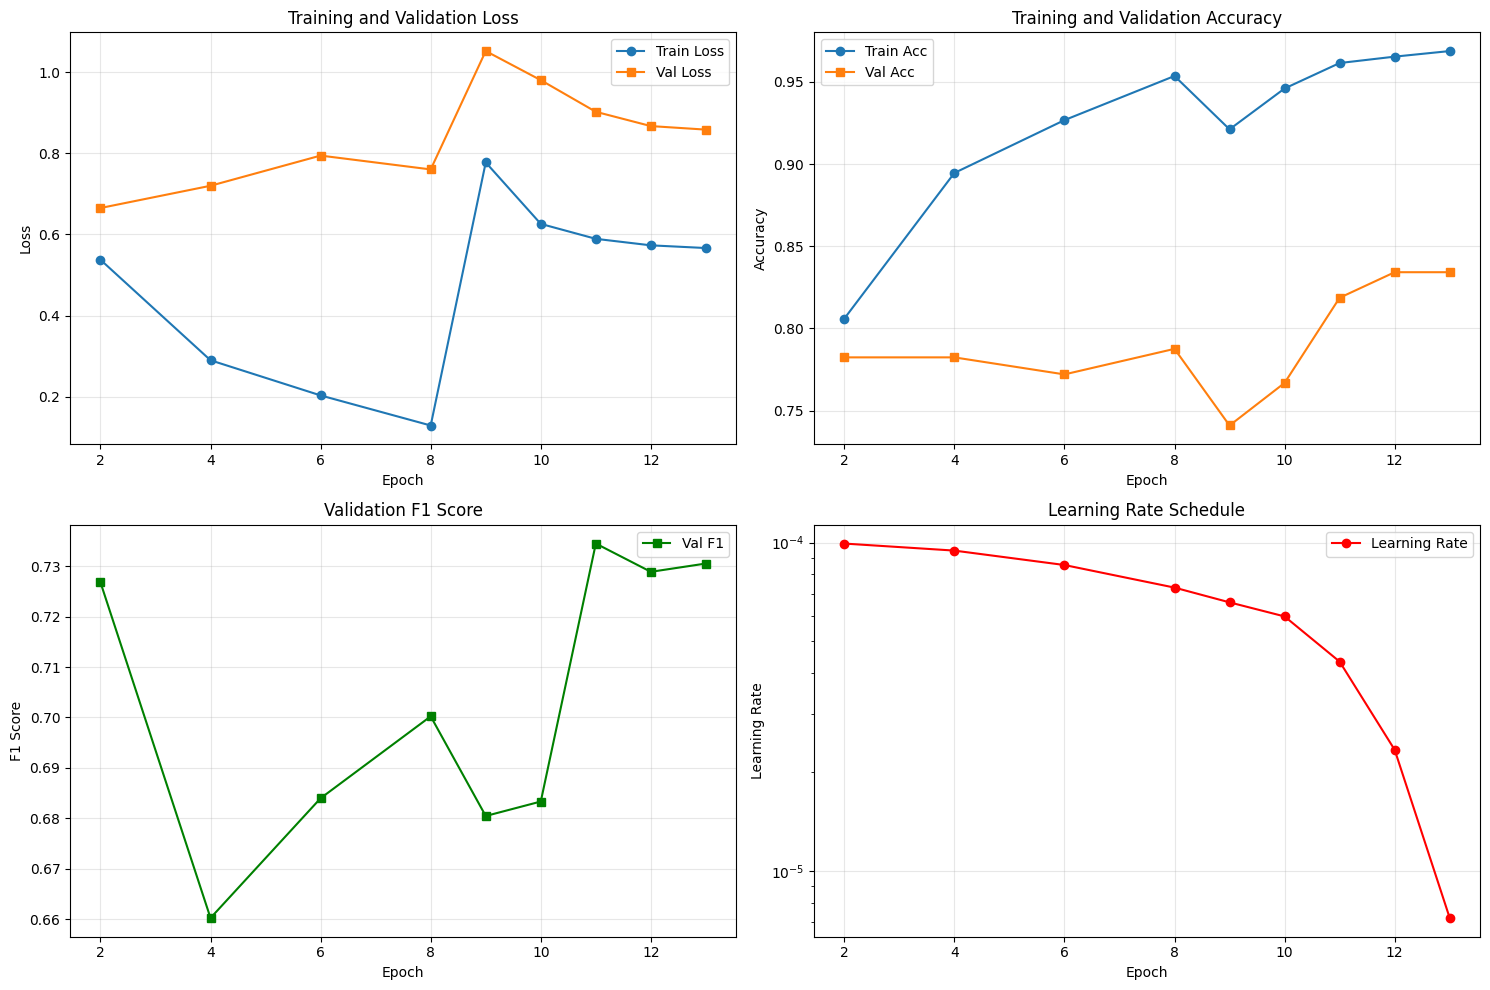

✓ Training history plotted and saved!


In [13]:
# Cell 8: Vẽ Training History

if len(history['epoch']) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history['epoch'], history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['epoch'], history['val_loss'], label='Val Loss', marker='s')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history['epoch'], history['train_acc'], label='Train Acc', marker='o')
    axes[0, 1].plot(history['epoch'], history['val_acc'], label='Val Acc', marker='s')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 Score
    axes[1, 0].plot(history['epoch'], history['val_f1'], label='Val F1', marker='s', color='green')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].set_title('Validation F1 Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 1].plot(history['epoch'], history['lr'], label='Learning Rate', marker='o', color='red')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(DIR_FIGURES, 'training_history.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Training history plotted and saved!")
else:
    print("No training history available.")